# GRU(Gate Recurrent Unit) Network on Predicting Stock Price

In [1]:
import torch
from torch import nn, optim
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from ta import momentum

# Set device: GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preprocess Dataset

In [2]:
# Load training data
data_train = pd.read_csv('./dataset/train.csv')
data_train = data_train.dropna()
data_train['Date'] = pd.to_datetime(data_train['Date'])
data_train['Close'] = data_train['Close'].astype(float)
# Load validation data
data_val = pd.read_csv('./dataset/val.csv')
data_val = data_val.dropna()
data_val['Date'] = pd.to_datetime(data_val['Date'])
data_val['Close'] = data_val['Close'].astype(float)


In [3]:
data_train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2007-01-03,1418.030029,1429.420044,1407.859985,1416.599976,1416.599976,3429160000
1,2007-01-04,1416.599976,1421.839966,1408.430054,1418.339966,1418.339966,3004460000
2,2007-01-05,1418.339966,1418.339966,1405.750000,1409.709961,1409.709961,2919400000
3,2007-01-08,1409.260010,1414.979980,1403.969971,1412.839966,1412.839966,2763340000
4,2007-01-09,1412.839966,1415.609985,1405.420044,1412.109985,1412.109985,3038380000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2416 entries, 0 to 2415
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2416 non-null   datetime64[ns]
 1   Open       2416 non-null   float64       
 2   High       2416 non-null   float64       
 3   Low        2416 non-null   float64       
 4   Close      2416 non-null   float64       
 5   Adj Close  2416 non-null   float64       
 6   Volume     2416 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 132.3 KB


<Axes: >

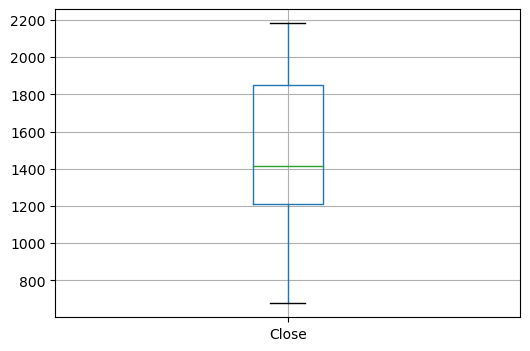

In [4]:
data_train.info()
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
data_train.boxplot(column=['Close'])

In [5]:
data_val.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-08-08,2183.760010,2185.439941,2177.850098,2180.889893,2180.889893,3327550000
1,2016-08-09,2182.239990,2187.659912,2178.610107,2181.739990,2181.739990,3334300000
2,2016-08-10,2182.810059,2183.409912,2172.000000,2175.489990,2175.489990,3254950000
3,2016-08-11,2177.969971,2188.449951,2177.969971,2185.790039,2185.790039,3423160000
4,2016-08-12,2183.739990,2186.280029,2179.419922,2184.050049,2184.050049,3000660000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 806 entries, 0 to 805
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       806 non-null    datetime64[ns]
 1   Open       806 non-null    float64       
 2   High       806 non-null    float64       
 3   Low        806 non-null    float64       
 4   Close      806 non-null    float64       
 5   Adj Close  806 non-null    float64       
 6   Volume     806 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 44.2 KB


<Axes: >

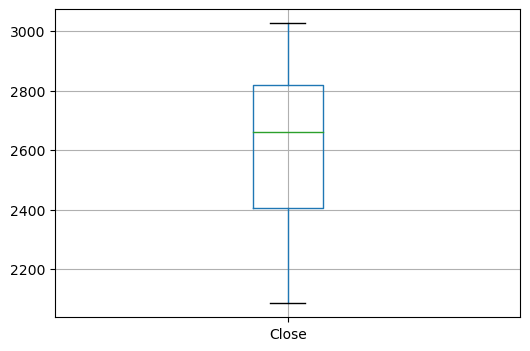

In [6]:
data_val.info()
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
data_val.boxplot(column=['Close'])

In [7]:
data_train.shape,data_val.shape

((2416, 7), (806, 7))

# Feature Engineering

In [8]:
#Traning set
# Add technical indicators as features
data_train['SMA_5'] = data_train['Close'].rolling(window=5).mean()
data_train['SMA_10'] = data_train['Close'].rolling(window=10).mean()
data_train['RSI'] = momentum.rsi(data_train['Close'], window=14)
# Delete rows corresponding to missing values
data_train = data_train.dropna()
#Validation set
# Add technical indicators as features
data_val['SMA_5'] = data_val['Close'].rolling(window=5).mean()
data_val['SMA_10'] = data_val['Close'].rolling(window=10).mean()
data_val['RSI'] = momentum.rsi(data_val['Close'], window=14)
# Delete rows corresponding to missing values
data_val = data_val.dropna()

# MinMaxScaler 

In [9]:
#Training set
scaler = MinMaxScaler()
data_train[['Close', 'SMA_5', 'SMA_10', 'RSI']] = scaler.fit_transform(data_train[['Close', 'SMA_5', 'SMA_10', 'RSI']])

X_train = data_train[['Close', 'SMA_5', 'SMA_10', 'RSI']].values[:-1]
y_train = data_train['Close'].values[1:]

X_train = torch.from_numpy(X_train).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)

X_train = X_train.view(-1, 1, 4).to(device)
y_train = y_train.view(-1, 1).to(device)

#Validation set
scaler = MinMaxScaler()
data_val[['Close', 'SMA_5', 'SMA_10', 'RSI']] = scaler.fit_transform(data_val[['Close', 'SMA_5', 'SMA_10', 'RSI']])

X_val = data_val[['Close', 'SMA_5', 'SMA_10', 'RSI']].values[:-1]
y_val = data_val['Close'].values[1:]

X_val = torch.from_numpy(X_val).type(torch.Tensor)
y_val = torch.from_numpy(y_val).type(torch.Tensor)

X_val = X_val.view(-1, 1, 4).to(device)
y_val = y_val.view(-1, 1).to(device)

# Define a Net: GRU

In [10]:
# Define GRU model
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, _ = self.gru(x, h0.detach())
        out = self.fc(out[:, -1, :])
        out = out.view(-1, 1)  # resize into (batch_size, 1, 1)
        return out

In [11]:
# Define hyperparameters
input_dim = 4  # The input dimension is 4, which is the number of features
hidden_dim = 32
output_dim = 1
num_layers = 2
num_epochs = 100


# Set the Loss & Optimizer

In [12]:
# Declare GRU model
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)


# Train the model

Epoch: 10/100, Loss: 0.09942616522312164
Epoch: 20/100, Loss: 0.036083076149225235
Epoch: 30/100, Loss: 0.012014507316052914
Epoch: 40/100, Loss: 0.0028622334357351065
Epoch: 50/100, Loss: 0.0013188584707677364
Epoch: 60/100, Loss: 0.0008857227512635291
Epoch: 70/100, Loss: 0.00023200924624688923
Epoch: 80/100, Loss: 0.00027898745611310005
Epoch: 90/100, Loss: 0.00019891450938303024
Epoch: 100/100, Loss: 0.00018409798212815076


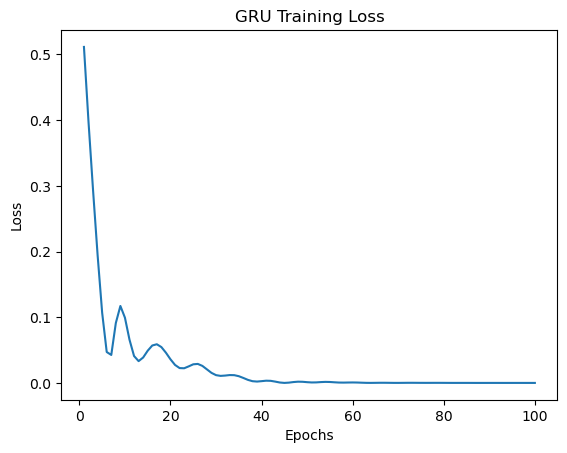

Model saved.


In [13]:
# Train the model
import time
model.train()
losses_GRU = []
start_time=time.time()
# train_predicted = []
# train_actual = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    # Set an appropriate gradient norm threshold
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1) 
    loss.backward()
    optimizer.step()
    
#     # Calculate predicted results and actual results on the training set
#     model.eval()
#     with torch.no_grad():
#         train_predicted = model(X_train)
#         train_predicted = scaler.inverse_transform(np.repeat(predicted.cpu().numpy(), 4, axis=1))  # 反归一化并调整形状
#         train_actual = scaler.inverse_transform(np.repeat(y_train.cpu().numpy(), 4, axis=1)) # 反归一化并调整形状

        
    # Calculate loss value
    if (epoch + 1) % 10 == 0:
        print(f'Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item()}')
    losses_GRU.append(loss.item())

end_time=time.time()

# Plot loss and epoch graphs
plt.plot(range(1, num_epochs+1), losses_GRU)
plt.title('GRU Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()
# # Save predicted results and actual results on the training set
# train_predicted = np.concatenate(train_predicted)
# train_actual = np.concatenate(train_actual)
# Save model
torch.save(model.state_dict(), 'gru_model.pth')
print('Model saved.')




In [14]:
training_time=end_time-start_time
training_time

0.3704867362976074

# Evaluate the model

In [14]:
# Load the trained model
model.load_state_dict(torch.load('gru_model.pth'))
model

GRU(
  (gru): GRU(4, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [15]:
#Output the prediction results on the validation set
model.eval()  # Switch to evaluation mode
with torch.no_grad():
    predicted = model(X_val)
    predicted = scaler.inverse_transform(np.repeat(predicted.cpu().numpy(), 4, axis=1))  # Denormalize and reshape
    actual = scaler.inverse_transform(np.repeat(y_val.cpu().numpy(), 4, axis=1)) # Denormalize and reshape

    # Print prediction results
    print("Predicted\tActual")
    for i in range(len(predicted)):
        print(f"{predicted[i][0]}\t{actual[i][0]}")



Predicted	Actual
2182.41650390625	2169.0400390625
2179.4267578125	2180.3798828125
2185.280517578125	2176.1201171875
2182.39404296875	2170.949951171875
2179.39404296875	2170.860107421875
2178.835693359375	2179.97998046875
2184.1826171875	2186.47998046875
2187.792724609375	2186.159912109375
2188.287109375	2181.300048828125
2186.609375	2127.81005859375
2162.51171875	2159.0400390625
2173.0947265625	2127.02001953125
2157.446044921875	2125.77001953125
2151.899169921875	2147.260009765625
2156.663818359375	2139.159912109375
2154.016357421875	2139.1201171875
2151.70361328125	2139.760009765625
2151.609619140625	2163.1201171875
2161.70703125	2177.179931640625
2168.394775390625	2164.68994140625
2166.618896484375	2146.10009765625
2160.5068359375	2159.929931640625
2167.38525390625	2171.3701171875
2172.961669921875	2151.1298828125
2164.49267578125	2168.27001953125
2171.203125	2161.199951171875
2170.376953125	2150.489990234375
2166.45458984375	2159.72998046875
2168.728759765625	2160.77001953125
2169.3

In [16]:
import numpy as np
# Assume that the prediction results of the model on the validation data are stored in predicted
# Assume the actual value is stored in actual
# Calculate difference
diff = predicted - actual
# Calculate the difference of squares
squared_diff = np.square(diff)
# Calculate MSE
mse = np.mean(squared_diff)
print(f"MSE: {mse}")

MSE: 502.140869140625


In [17]:
# # Assume x_train_torch and x_val_torch are the input data of your training set and validation set respectively
# # Assume y_train and y_val are the actual output data of your training set and validation set respectively

# model.eval()

# # Make predictions on training and validation sets
# with torch.no_grad():
#     y_train_pred = model(X_train)
#     y_val_pred = model(X_val)

# # Denormalize prediction results np.repeat(predicted.cpu().numpy(), 4, axis=1
# y_train_pred = scaler.inverse_transform(np.repeat(y_train_pred.cpu().numpy(), 4, axis=1))
# y_val_pred = scaler.inverse_transform(np.repeat(y_val_pred.cpu().numpy(), 4, axis=1))
# y_train_original = scaler.inverse_transform(y_train)
# y_val_original = scaler.inverse_transform(y_val)

# # Visualize prediction results for training and validation sets
# plt.figure(dpi=400)
# plt.figure(figsize=(20, 5))
# plt.plot(y_train_original, color='blue', label='Training Set Price')
# plt.plot(y_train_pred, color='green', label='Training Set Prediction')
# plt.plot(range(len(y_train_original), len(y_train_original) + len(y_val_original)), y_val_original, color='orange', label='Val Price')
# plt.plot(range(len(y_train_original), len(y_train_original) + len(y_val_original)), y_val_pred, color='purple', label='Val Prediction')
# plt.xlabel('Days')
# plt.ylabel('Price')
# plt.legend()
# plt.savefig("Prediction_Result.png", dpi=500)
# plt.show()

# # # Save the original prices and prediction results of the validation set to a CSV file
# # df_result = pd.DataFrame({'Original': np.concatenate([y_train_original, y_val_original]), 'Prediction': np.concatenate([y_train_pred, y_val_pred])})
# # df_result.to_csv("Prediction_Result.csv", index=False)



In [18]:
# import matplotlib.pyplot as plt

# import torch

# # Convert predicted and actual values to numpy array
# train_predicted = train_predicted.squeeze().cpu().numpy()
# train_actual = train_actual.squeeze().cpu().numpy()

# # It is assumed here that you also have the definitions of val_predicted and val_actual
# val_predicted = val_predicted.squeeze().cpu().numpy()
# val_actual = val_actual.squeeze().cpu().numpy()


# # Create a new Figure object and a subfigure
# fig, ax = plt.subplots(figsize=(10, 6))

# # Plot the predicted and actual values for the training and validation sets
# ax.plot(train_predicted, label='Train Predicted')
# ax.plot(train_actual, label='Train Actual')
# ax.plot(val_predicted, label='Validation Predicted')
# ax.plot(val_actual, label='Validation Actual')

# # Add legend
# ax.legend()

# # Add title and axis labels
# ax.set_title('Predicted vs Actual')
# ax.set_xlabel('Time')
# ax.set_ylabel('Price')

# # display graphics
# plt.show()



In [19]:
# plt.figure(figsize=(10, 6))
# plt.plot(predicted[:, 0], label='Validation Predicted')
# plt.plot(actual[:, 0], label='Validation Actual')
# plt.plot(train_predicted[:, 0], label='Train Predicted')
# plt.plot(train_actual[:, 0], label='Train Actual')
# plt.xlabel('Days')
# plt.ylabel('Close')
# plt.title('GRU')
# plt.legend()
# plt.show()



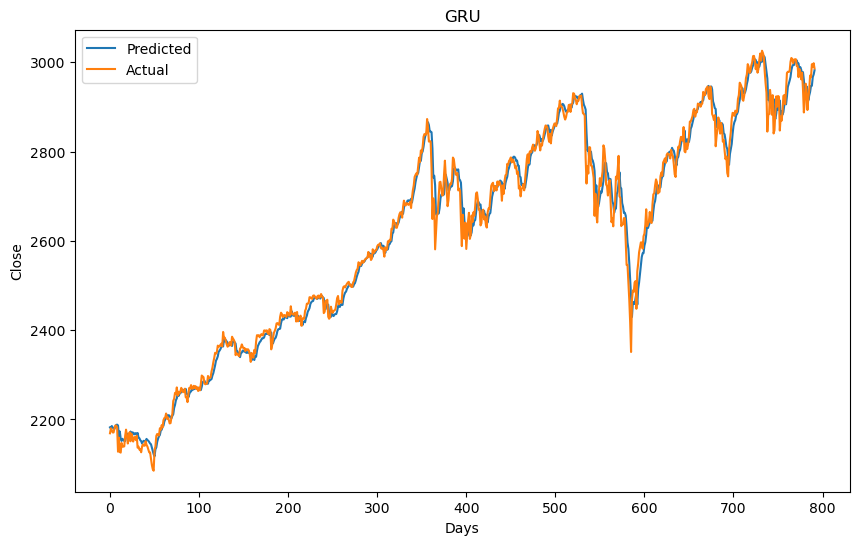

In [20]:
import matplotlib.pyplot as plt

# Draw prediction result image
plt.figure(figsize=(10, 6))
plt.plot(predicted[:, 0], label='Predicted')
plt.plot(actual[:, 0], label='Actual')
plt.xlabel('Days')
plt.ylabel('Close')
plt.title('GRU')
plt.legend()
plt.show()

# Backtest

In [21]:
def backtest(predictions, original_prices, threshold=0.015, initial_cash=500000):
    """
    Backtest function to simulate trading based on the model's predictions.

    :param predictions: The predicted prices from the model.
    :param original_prices: The actual prices of the stock.
    :param threshold: The threshold for making a trade decision.
    :param initial_cash: The initial cash in the portfolio.
    :return: The final portfolio value and the total return.
    """
    cash = initial_cash
    shares = 0
    total_assets = initial_cash

    for i in range(1, len(predictions)):
        predicted_change = (predictions[i] - original_prices[i - 1]) / original_prices[i - 1]
        actual_change = (original_prices[i] - original_prices[i - 1]) / original_prices[i - 1]

        # Decision to buy
        if predicted_change > threshold and cash >= original_prices[i]:
            shares_bought = cash // original_prices[i]
            shares += shares_bought
            cash -= shares_bought * original_prices[i]

        # Decision to sell
        elif predicted_change < -threshold and shares > 0:
            cash += shares * original_prices[i]
            shares = 0

        # Update total assets value
        total_assets = cash + shares * original_prices[i]

    total_return = total_assets - initial_cash
    return total_assets, total_return

In [22]:
initial_cash = 500000
threshold = 0.015
# Applying the backtest function to the LSTM model's predictions
final_assets, total_return = backtest(predicted[:, 0],actual[:, 0], threshold=threshold, initial_cash=initial_cash)
return_rate = (total_return/initial_cash)*100
print("Final Assets:", final_assets, "Total Return:", total_return, "Return Rate:",return_rate)

Final Assets: 658474.5100097656 Total Return: 158474.51000976562 Return Rate: 31.694902001953125


# Long Short Term Memory (LSTM) Network on Predicting Stock Price

Epoch: 10/100, Loss: 0.09514845162630081
Epoch: 20/100, Loss: 0.05261813476681709
Epoch: 30/100, Loss: 0.029512178152799606
Epoch: 40/100, Loss: 0.008662193082273006
Epoch: 50/100, Loss: 0.0018580376636236906
Epoch: 60/100, Loss: 0.0011629117652773857
Epoch: 70/100, Loss: 0.0007303308229893446
Epoch: 80/100, Loss: 0.0005215035052970052
Epoch: 90/100, Loss: 0.00035868381382897496
Epoch: 100/100, Loss: 0.0003129698452539742


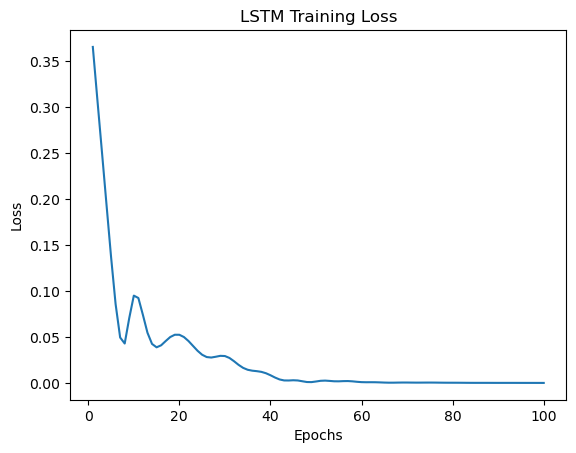

Model saved.
Predicted	Actual
2210.009033203125	2169.0400390625
2209.060302734375	2180.3798828125
2207.60107421875	2176.1201171875
2207.2119140625	2170.949951171875
2206.797119140625	2170.860107421875
2206.325927734375	2179.97998046875
2206.15673828125	2186.47998046875
2206.48681640625	2186.159912109375
2206.9296875	2181.300048828125
2207.763916015625	2127.81005859375
2201.141357421875	2159.0400390625
2201.22216796875	2127.02001953125
2193.765869140625	2125.77001953125
2189.956787109375	2147.260009765625
2189.486328125	2139.159912109375
2188.327392578125	2139.1201171875
2186.5556640625	2139.760009765625
2186.02880859375	2163.1201171875
2188.831298828125	2177.179931640625
2191.441650390625	2164.68994140625
2192.212646484375	2146.10009765625
2190.253173828125	2159.929931640625
2193.24267578125	2171.3701171875
2195.969482421875	2151.1298828125
2192.730224609375	2168.27001953125
2195.50244140625	2161.199951171875
2195.88134765625	2150.489990234375
2194.51806640625	2159.72998046875
2194.930

In [15]:
import torch
from torch import nn, optim
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from ta import momentum
import time

# Set device: GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

# Load training data
data_train = pd.read_csv('./dataset/train.csv')
data_train = data_train.dropna()
data_train['Date'] = pd.to_datetime(data_train['Date'])
data_train['Close'] = data_train['Close'].astype(float)

# Add technical indicators as features
data_train['SMA_5'] = data_train['Close'].rolling(window=5).mean()
data_train['SMA_10'] = data_train['Close'].rolling(window=10).mean()
data_train['RSI'] = momentum.rsi(data_train['Close'], window=14)

# Delete rows corresponding to missing values
data_train = data_train.dropna()

scaler = MinMaxScaler()
data_train[['Close', 'SMA_5', 'SMA_10', 'RSI']] = scaler.fit_transform(data_train[['Close', 'SMA_5', 'SMA_10', 'RSI']])

X_train = data_train[['Close', 'SMA_5', 'SMA_10', 'RSI']].values[:-1]
y_train = data_train['Close'].values[1:]

X_train = torch.from_numpy(X_train).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)

X_train = X_train.view(-1, 1, 4).to(device)
y_train = y_train.view(-1, 1).to(device)

# Define hyperparameters
input_dim = 4  # The input dimension is 4, which is the number of features
hidden_dim = 32
output_dim = 1
num_layers = 2
num_epochs = 100

# Declare LSTM model
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

start_time=time.time()
# Training model
model.train()
losses_LSTM = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)  # Set an appropriate gradient norm threshold
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item()}')
    losses_LSTM.append(loss.item())
    
end_time=time.time()
# Plot loss and epoch graphs
plt.plot(range(1, num_epochs+1), losses_LSTM)
plt.title('LSTM Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()
# Save model
torch.save(model.state_dict(), 'LSTM.pth')
print('Model saved.')

# Load verification data
data_val = pd.read_csv('./dataset/val.csv')
data_val = data_val.dropna()
data_val['Date'] = pd.to_datetime(data_val['Date'])
data_val['Close'] = data_val['Close'].astype(float)

# Add technical indicators as features
data_val['SMA_5'] = data_val['Close'].rolling(window=5).mean()
data_val['SMA_10'] = data_val['Close'].rolling(window=10).mean()
data_val['RSI'] = momentum.rsi(data_val['Close'], window=14)

data_val = data_val.dropna()

scaler = MinMaxScaler()
data_val[['Close', 'SMA_5', 'SMA_10', 'RSI']] = scaler.fit_transform(data_val[['Close', 'SMA_5', 'SMA_10', 'RSI']])

X_val = data_val[['Close', 'SMA_5', 'SMA_10', 'RSI']].values[:-1]
y_val = data_val['Close'].values[1:]

X_val = torch.from_numpy(X_val).type(torch.Tensor)
y_val = torch.from_numpy(y_val).type(torch.Tensor)

X_val = X_val.view(-1, 1, 4).to(device)
y_val = y_val.view(-1, 1).to(device)

# Output prediction results
model.eval()  # Switch to evaluation mode
with torch.no_grad():
    predicted = model(X_val)
    predicted = scaler.inverse_transform(np.repeat(predicted.cpu().numpy(), 4, axis=1))  # Denormalize and reshape
    actual = scaler.inverse_transform(np.repeat(y_val.cpu().numpy(), 4, axis=1))  # Denormalize and reshape

    # Print prediction results
    print("Predicted\tActual")
    for i in range(len(predicted)):
        print(f"{predicted[i][0]}\t{actual[i][0]}")


In [16]:
time=end_time-start_time
time

0.4225480556488037

In [24]:
import numpy as np

# Assume that the prediction results of the model on the validation data are stored in predicted
# Assume the actual value is stored in actual

# Calculate difference
diff = predicted - actual

# Calculate the difference of squares
squared_diff = np.square(diff)

# Calculate MSE
mse = np.mean(squared_diff)

print(f"MSE: {mse}")

MSE: 642.0755004882812


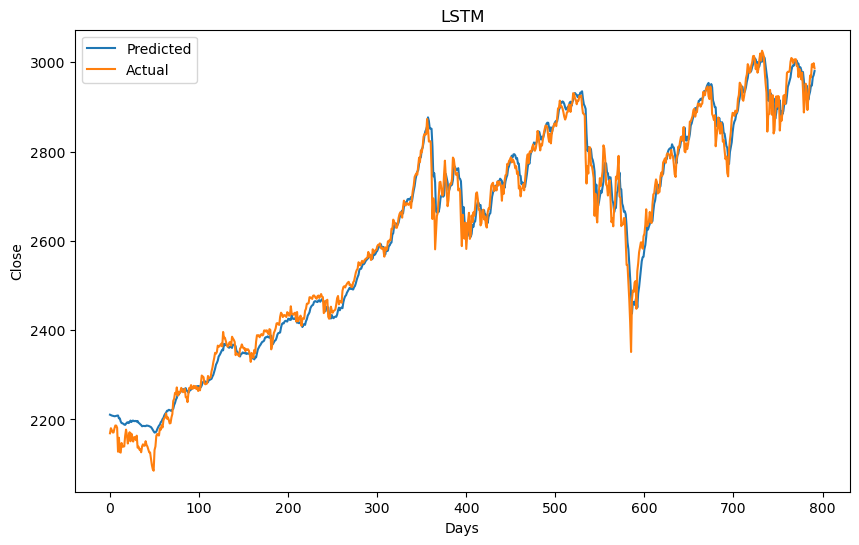

In [25]:
import matplotlib.pyplot as plt

# Draw prediction result image
plt.figure(figsize=(10, 6))
plt.plot(predicted[:, 0], label='Predicted')
plt.plot(actual[:, 0], label='Actual')
plt.xlabel('Days')
plt.ylabel('Close')
plt.title('LSTM')
plt.legend()
plt.show()

# Bi-Directional Long Short Term Memory (Bi-LSTM) Network on Predicting Stock Price

Epoch: 10/100, Loss: 0.054390400648117065
Epoch: 20/100, Loss: 0.023472482338547707
Epoch: 30/100, Loss: 0.010719429701566696
Epoch: 40/100, Loss: 0.0018111859681084752
Epoch: 50/100, Loss: 0.002150544198229909
Epoch: 60/100, Loss: 0.0006157692987471819
Epoch: 70/100, Loss: 0.00043951222323812544
Epoch: 80/100, Loss: 0.000323812710121274
Epoch: 90/100, Loss: 0.00028610785375349224
Epoch: 100/100, Loss: 0.00024315042537637055


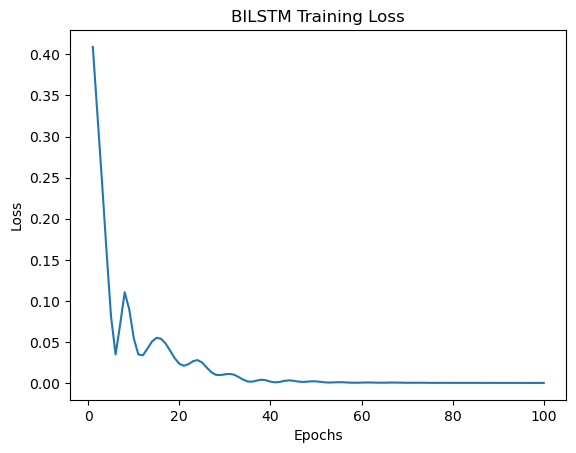

Model saved.
Predicted	Actual
2202.306640625	2186.47998046875
2204.138427734375	2186.159912109375
2204.53271484375	2181.300048828125
2204.11083984375	2127.81005859375
2188.859619140625	2159.0400390625
2194.474365234375	2127.02001953125
2183.080322265625	2125.77001953125
2178.902587890625	2147.260009765625
2181.470947265625	2139.159912109375
2179.405517578125	2139.1201171875
2177.543212890625	2139.760009765625
2177.159912109375	2163.1201171875
2183.468017578125	2177.179931640625
2187.983154296875	2164.68994140625
2187.1689453125	2146.10009765625
2182.9013671875	2159.929931640625
2187.77734375	2171.3701171875
2191.94287109375	2151.1298828125
2186.091552734375	2168.27001953125
2190.9609375	2161.199951171875
2190.53173828125	2150.489990234375
2187.839111328125	2159.72998046875
2189.37158203125	2160.77001953125
2189.666259765625	2153.739990234375
2187.090087890625	2163.659912109375
2189.933349609375	2136.72998046875
2182.48779296875	2139.179931640625
2181.345458984375	2132.550048828125
2178

In [17]:
import torch
from torch import nn, optim
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from ta import momentum
import time

# Set device: GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define Bi-LSTM model
class BiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(BiLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, _ = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        out = out.view(-1, 1)  # resize into (batch_size, 1, 1)
        return out

# Load training data
data_train = pd.read_csv('./dataset/train.csv')
data_train = data_train.dropna()
data_train['Date'] = pd.to_datetime(data_train['Date'])
data_train['Close'] = data_train['Close'].astype(float)

# Add technical indicators as features
data_train['SMA_5'] = data_train['Close'].rolling(window=5).mean()
data_train['SMA_10'] = data_train['Close'].rolling(window=10).mean()
data_train['RSI'] = momentum.rsi(data_train['Close'], window=20)

# Delete rows corresponding to missing values
data_train = data_train.dropna()

scaler = MinMaxScaler()
data_train[['Close', 'SMA_5', 'SMA_10', 'RSI']] = scaler.fit_transform(data_train[['Close', 'SMA_5', 'SMA_10', 'RSI']])

X_train = data_train[['Close', 'SMA_5', 'SMA_10', 'RSI']].values[:-1]
y_train = data_train['Close'].values[1:]

X_train = torch.from_numpy(X_train).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)

X_train = X_train.view(-1, 1, 4).to(device)
y_train = y_train.view(-1, 1).to(device)

# Define hyperparameters
input_dim = 4  # The input dimension is 4, which is the number of features
hidden_dim = 32
output_dim = 1
num_layers = 2
num_epochs = 100

# Declare Bi-LSTM model
model = BiLSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

start_time=time.time()
# Training model
model.train()
losses_BILSTM = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)  # Set an appropriate gradient norm threshold
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item()}')
    losses_BILSTM.append(loss.item())

end_time=time.time()
# Plot loss and epoch graphs
plt.plot(range(1, num_epochs+1), losses_BILSTM)
plt.title('BILSTM Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()
# Save model
torch.save(model.state_dict(), 'bilstm_model.pth')
print('Model saved.')

# Load validation data
data_val = pd.read_csv('./dataset/val.csv')
data_val = data_val.dropna()
data_val['Date'] = pd.to_datetime(data_val['Date'])
data_val['Close'] = data_val['Close'].astype(float)

# Add technical indicators as features
data_val['SMA_5'] = data_val['Close'].rolling(window=5).mean()
data_val['SMA_10'] = data_val['Close'].rolling(window=10).mean()
data_val['RSI'] = momentum.rsi(data_val['Close'],window=20)

data_val = data_val.dropna()

scaler = MinMaxScaler()
data_val[['Close', 'SMA_5', 'SMA_10', 'RSI']] = scaler.fit_transform(data_val[['Close', 'SMA_5', 'SMA_10', 'RSI']])

X_val = data_val[['Close', 'SMA_5', 'SMA_10', 'RSI']].values[:-1]
y_val = data_val['Close'].values[1:]

X_val = torch.from_numpy(X_val).type(torch.Tensor)
y_val = torch.from_numpy(y_val).type(torch.Tensor)

X_val = X_val.view(-1, 1, 4).to(device)
y_val = y_val.view(-1, 1).to(device)

# Output prediction results
model.eval()  # Switch to evaluation mode
with torch.no_grad():
    predicted = model(X_val)
    predicted = scaler.inverse_transform(np.repeat(predicted.cpu().numpy(), 4, axis=1))  # Denormalize and reshape
    actual = scaler.inverse_transform(np.repeat(y_val.cpu().numpy(), 4, axis=1)) # Denormalize and reshape

    # Print prediction results
    print("Predicted\tActual")
    for i in range(len(predicted)):
        print(f"{predicted[i][0]}\t{actual[i][0]}")

In [18]:
time=end_time-start_time
time

0.8322639465332031

In [27]:
import numpy as np

# Assume that the prediction results of the model on the validation data are stored in predicted
# Assume the actual value is stored in actual

# Calculate difference
diff = predicted - actual

# Calculate the difference of squares
squared_diff = np.square(diff)

# Calculate MSE
mse = np.mean(squared_diff)

print(f"MSE: {mse}")

MSE: 566.4952392578125


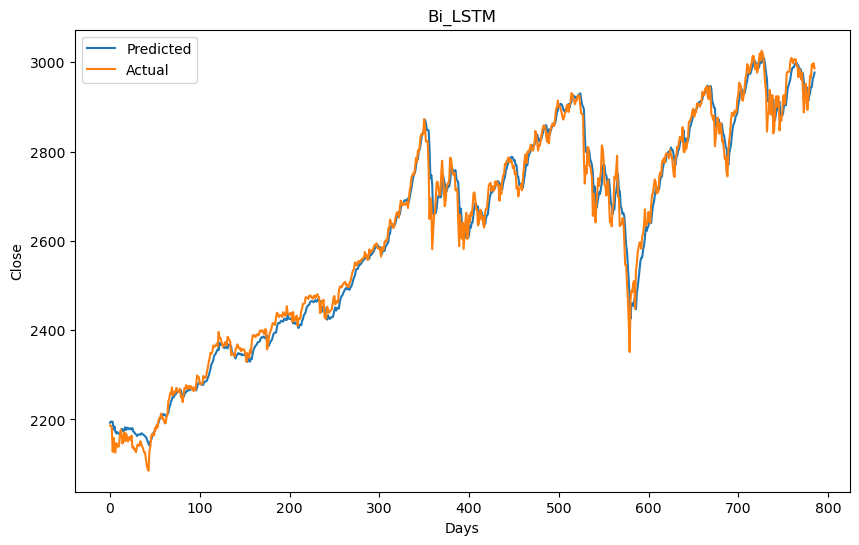

In [28]:
import matplotlib.pyplot as plt

# Draw prediction result image
plt.figure(figsize=(10, 6))
plt.plot(predicted[:, 0], label='Predicted')
plt.plot(actual[:, 0], label='Actual')
plt.xlabel('Days')
plt.ylabel('Close')
plt.title('Bi_LSTM')
plt.legend()
plt.show()

# GRU(Gate Recurrent Unit) Network on Predicting Stock Price(Without Feature Engineering)

Epoch: 10/100, Loss: 0.10284342616796494
Epoch: 20/100, Loss: 0.05474935099482536
Epoch: 30/100, Loss: 0.029673350974917412
Epoch: 40/100, Loss: 0.008918294683098793
Epoch: 50/100, Loss: 0.0012783758575096726
Epoch: 60/100, Loss: 0.0017772268038243055
Epoch: 70/100, Loss: 0.0002873134217225015
Epoch: 80/100, Loss: 0.0003480144659988582
Epoch: 90/100, Loss: 0.00018761928367894143
Epoch: 100/100, Loss: 0.0001988536969292909


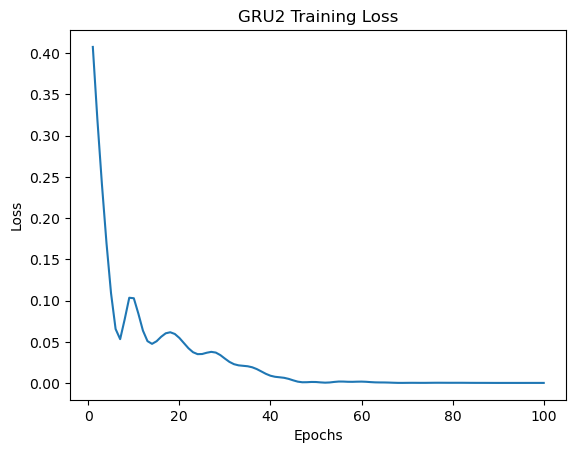

Model saved.
Actual: [2181.74], Predicted: [2196.1536]
Actual: [2175.49], Predicted: [2196.8594]
Actual: [2185.79], Predicted: [2191.6816]
Actual: [2184.05], Predicted: [2200.228]
Actual: [2190.15], Predicted: [2198.7795]
Actual: [2178.15], Predicted: [2203.8665]
Actual: [2182.22], Predicted: [2193.882]
Actual: [2187.02], Predicted: [2197.258]
Actual: [2183.87], Predicted: [2201.2532]
Actual: [2182.64], Predicted: [2198.63]
Actual: [2186.9], Predicted: [2197.607]
Actual: [2175.44], Predicted: [2201.153]
Actual: [2172.47], Predicted: [2191.6404]
Actual: [2169.04], Predicted: [2189.189]
Actual: [2180.38], Predicted: [2186.3652]
Actual: [2176.12], Predicted: [2195.7305]
Actual: [2170.95], Predicted: [2192.2026]
Actual: [2170.86], Predicted: [2187.9365]
Actual: [2179.98], Predicted: [2187.8625]
Actual: [2186.48], Predicted: [2195.3987]
Actual: [2186.16], Predicted: [2200.803]
Actual: [2181.3], Predicted: [2200.5364]
Actual: [2127.81], Predicted: [2196.4941]
Actual: [2159.04], Predicted: [2

In [19]:
import torch
from torch import nn, optim
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import time

# Set device: GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define GRU model
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, _ = self.gru(x, h0.detach())
        out = self.fc(out[:, -1, :])
        return out

# Load training data
data_train = pd.read_csv('./dataset/train.csv')
data_train = data_train.dropna()
data_train['Date'] = pd.to_datetime(data_train['Date'])
data_train['Close'] = data_train['Close'].astype(float)

scaler = MinMaxScaler()
data_train['Close'] = scaler.fit_transform(data_train['Close'].values.reshape(-1, 1))

X_train = data_train['Close'].values[:-1]
y_train = data_train['Close'].values[1:]

X_train = torch.from_numpy(X_train).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)

X_train = X_train.view(-1, 1, 1).to(device)
y_train = y_train.view(-1, 1).to(device)

# Define hyperparameters
input_dim = 1
hidden_dim = 32
output_dim = 1
num_layers = 2
num_epochs = 100

# Declare GRU model
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

start_time=time.time()
# Training model
model.train()
losses_GRU2 = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item()}')
    losses_GRU2.append(loss.item())

end_time=time.time()
# Plot loss and epoch graphs
plt.plot(range(1, num_epochs+1), losses_GRU2)
plt.title('GRU2 Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()
# Save model
torch.save(model.state_dict(), 'gru_model_1.pth')
print('Model saved.')

# Load verification data
data_val = pd.read_csv('./dataset/val.csv')
data_val = data_val.dropna()
data_val['Date'] = pd.to_datetime(data_val['Date'])
data_val['Close'] = data_val['Close'].astype(float)

scaler = MinMaxScaler()
data_val['Close'] = scaler.fit_transform(data_val['Close'].values.reshape(-1, 1))

X_val = data_val['Close'].values[:-1]
y_val = data_val['Close'].values[1:]

X_val = torch.from_numpy(X_val).type(torch.Tensor)
y_val = torch.from_numpy(y_val).type(torch.Tensor)

X_val = X_val.view(-1, 1, 1).to(device)
y_val = y_val.view(-1, 1).to(device)

# Load the trained model
model.load_state_dict(torch.load('gru_model_1.pth'))

# Make predictions on the validation set
model.eval()
with torch.no_grad():
    val_predictions = model(X_val)

# Denormalized prediction results
val_predictions = scaler.inverse_transform(val_predictions.cpu().numpy())
y_val = scaler.inverse_transform(y_val.cpu().numpy())

# Print prediction results
for i in range(len(y_val)):
    print(f'Actual: {y_val[i]}, Predicted: {val_predictions[i]}')

In [20]:
time=end_time-start_time
time

0.35597801208496094

In [30]:
import numpy as np

# Assume that the prediction results of the model on the validation data are stored in predicted
# Assume the actual value is stored in actual

# Calculate difference
diff = predicted - actual

# Calculate the difference of squares
squared_diff = np.square(diff)

# Calculate MSE
mse = np.mean(squared_diff)

print(f"MSE: {mse}")

MSE: 566.4952392578125


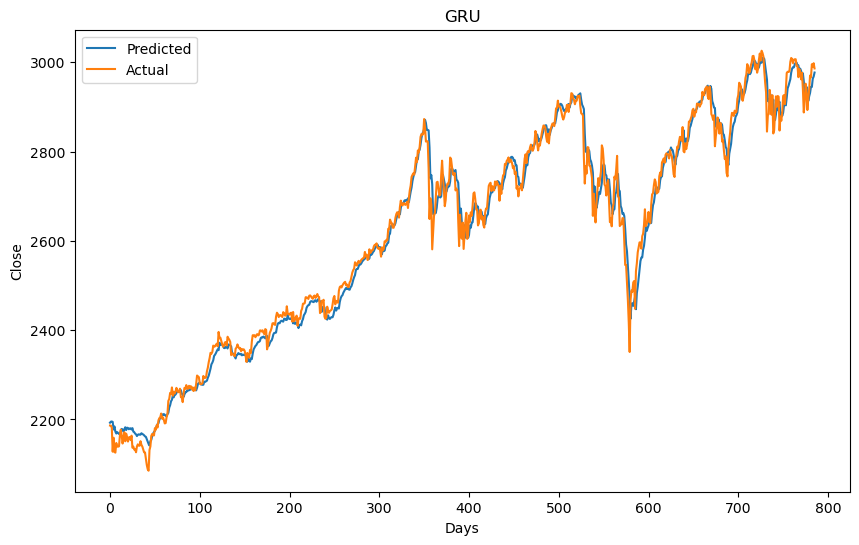

In [31]:
import matplotlib.pyplot as plt

# Draw prediction result image
plt.figure(figsize=(10, 6))
plt.plot(predicted[:, 0], label='Predicted')
plt.plot(actual[:, 0], label='Actual')
plt.xlabel('Days')
plt.ylabel('Close')
plt.title('GRU')
plt.legend()
plt.show()

# LOSS Comparison

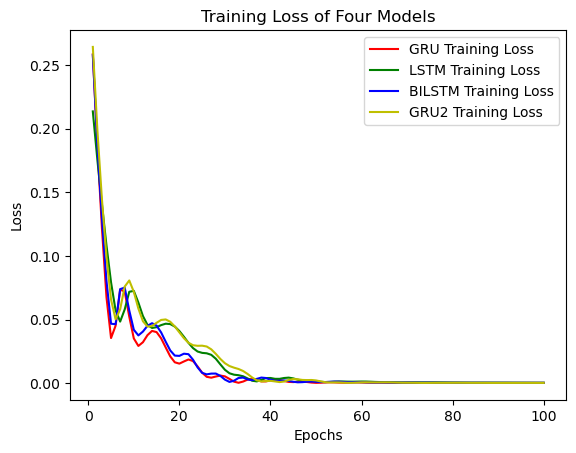

In [32]:
import matplotlib.pyplot as plt


epochs = range(1, len(losses_GRU) + 1)

plt.plot(epochs, losses_GRU, 'r', label='GRU Training Loss')
plt.plot(epochs, losses_LSTM, 'g', label='LSTM Training Loss')
plt.plot(epochs, losses_BILSTM, 'b', label='BILSTM Training Loss')
plt.plot(epochs, losses_GRU2, 'y', label='GRU2 Training Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss of Four Models')
plt.legend()

plt.show()
